<img src="figuras/logo.png" alt="logo" style="max-width: 450px;display: block">

<h1 style="text-align: center; font-size: 3rem;">Processamento e interpretação de
dados de campos potenciais  </h1>

<h1 style="text-align: center; font-size: 2.0rem;">Processando dados gravimetricos com Harmonica </h1>

## ℹ️ Sobre este tutorial


Neste tutorial, faremos um tour pelo Harmonica, uma biblioteca Python para modelagem direta, inversão e processamento de dados gravitacionais, com foco no fluxo de trabalho de processamento para produzir uma grade regular do _distúrbio de gravidade Bouguer_.

Para obter a perturbação gravitacional de Bouguer, é necessário calcular a distúrbio de gravidade como:
$$ \delta g(P) = g(P) - \gamma (P), $$
onde $g(P)$ e  $\gamma(P)$ são a gravidade observada e a gravidade normal no ponto $P$ respectivamente.

Em seguida, o efeito gravitacional produzido pelas massas topográficas conhecidas é removido para obter o _distúrbio de gravidade Bouguer_ como:
$$ \delta bg(P) = \delta g(P) - g_{topo}(P), $$
onde $g_{topo}(P)$ é o efeito gravitacional da topografia no ponto $P$. 

## Área de estudo

O **Complexo Ígneo de Bushveld** está localizado na África do Sul.
É a maior intrusão ígnea em camadas dentro da crosta terrestre.
Foi inclinado e erodido formando os afloramentos ao redor do que parece ser a borda de uma grande bacia geológica: a Bacia do Transvaal.

Tem aproximadamente 2 bilhões de anos e é dividido em quatro membros diferentes: os membros norte, sul, leste e oeste.
O Complexo Bushveld compreende a suíte Rustenburg Layered, os Lebowa Granites e os Rooiberg Felsics, que são cobertos pelos sedimentos Karoo.

<img src="figuras/study-area.png" style="max-width: 550px">

_[Webb et al, (2004)](https://doi.org/10.2113/107.1-2.207)_

## 🐍 Importe as bibliotecas necessárias

In [1]:
import pyproj
import pooch
import numpy as np
import xarray as xr
import verde as vd
import boule as bl
import harmonica as hm
import matplotlib.pyplot as plt

Aumente o tamanho das figuras do matplotlib

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

## Carregar dados de gravidade da África do Sul

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
data

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


Plote os dados em longitude e latitude (coordenadas geográficas):

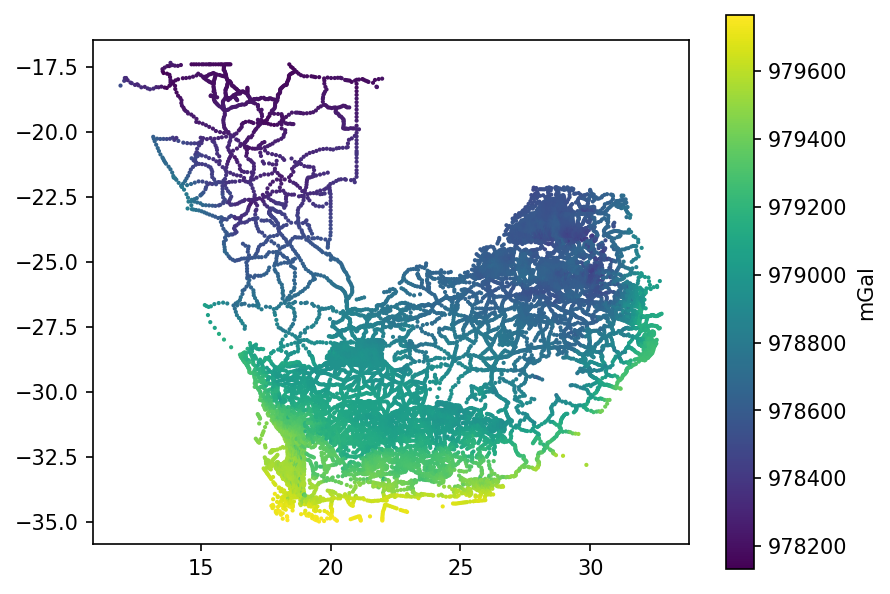

In [4]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

Quando plotamos dados em coordenadas geográficas, o mapa parece distorcido, precisamos projetá-lo em coordenadas planas.

## Corte o conjunto de dados em uma região menor

Vamos cortar o conjunto de dados em uma região menor usando **[Verde](https://www.fatiando.org/verde)**.

In [5]:
# Defina a região a ser cortada ([W, E, S, N]):
region_deg = (25, 32, -27, -23)
 
# Obtenha uma matriz com as coordenadas do conjunto de dados que estão dentro do region_cut: 
inside = vd.inside((data.longitude, data.latitude), region_deg)
# Obtenha um conjunto de dados menor e substitua-o no original:
data = data[inside]
data

,latitude,longitude,elevation,gravity
8848,-26.26334,25.01500,1230.16,978681.38
8849,-26.38713,25.01932,1297.00,978669.02
8850,-26.39667,25.02499,1304.84,978669.28
8851,-26.07668,25.04500,1165.24,978681.08
8852,-26.35001,25.07668,1262.47,978665.19
...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85
13175,-23.30000,31.52499,280.72,978798.55
13176,-23.19333,31.54832,245.67,978803.55
13177,-23.84833,31.57333,226.77,978808.44


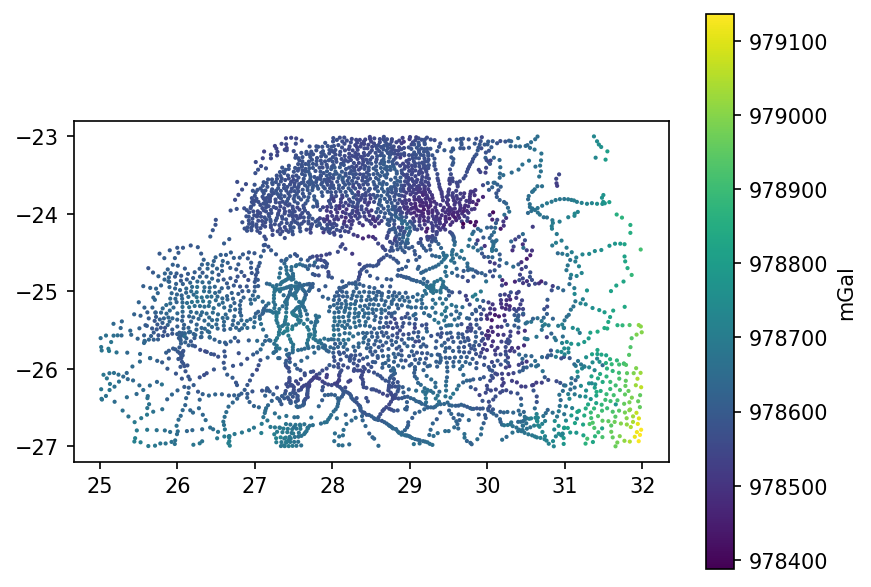

In [6]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Dados do projeto para coordenadas simples

Nós vamos usar **[pyproj](https://pypi.org/project/pyproj/)** para projetar como coordenadas cartesianas.

In [7]:
# Configure a projeção:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# Projete as coordenadas do conjunto de dados:
easting, northing = projection(data.longitude.values, data.latitude.values)

# Adicione estas coordenadas projetadas no conjunto de dados como colunas:
data = data.assign(easting=easting)
data = data.assign(northing=northing)
data

,latitude,longitude,elevation,gravity,easting,northing
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06


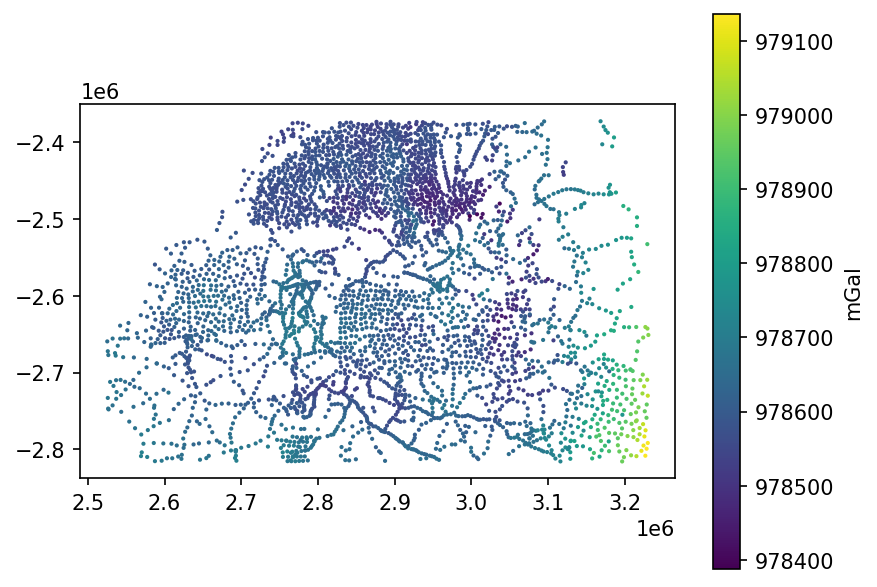

In [8]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

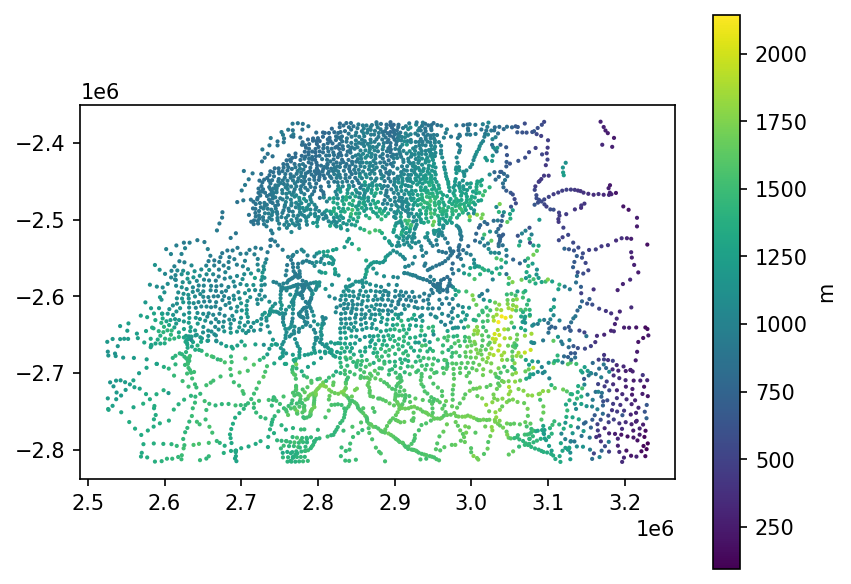

In [9]:
tmp = plt.scatter(data.easting, data.northing, c=data.elevation, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="m")
plt.show()

## Cálculo do distúrbio de gravidade 

O distúrbio de gravidade: 

$$ \delta g(P) = g(P) - \gamma(P), $$

A gravidade normal $\gamma(P)$ é calculado usando o elipsóide de referência _WGS84_.

Usaremos o  **[Boule](https://www.fatiando.org/boule)** para obter o elipsóide de referência e calcular a gravidade normal através do metódo `normal_gravity()`. 

In [10]:
# Selecione o elipsóide de referência
ell = bl.WGS84

# Calcule a distúrbio de gravidade:
gravity_disturbance = data.gravity - ell.normal_gravity(data.latitude, data.elevation)
# Adicione o distúrbio de gravidade ao conjunto de dados como uma coluna: 
data = data.assign(gravity_disturbance=gravity_disturbance)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785
...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373


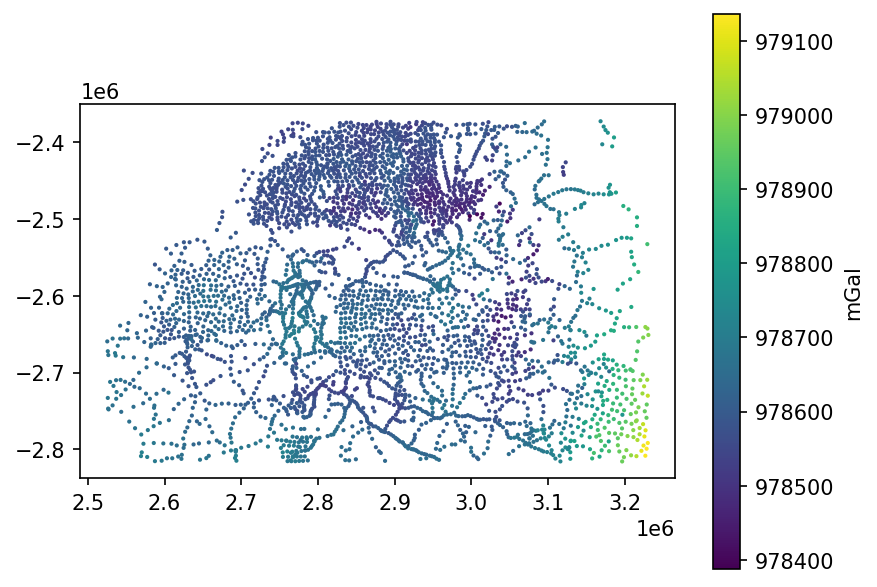

In [11]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Cálculo do distúrbio de gravidade Bouguer

O _distúrbio de gravidade Bouguer_ é definido como:

$$ \delta bg(P) = \delta g(P) - g_{topo}(P) $$

O efeito gravitacional da topografia($g_{topo}(P)$) é calculado em uma aproximação plana da Terra por modelagem direta usando prismas. 

**Passos:**
* Carregue um modelo digital de elevação (MDE) da área de levantamento.
* Projete o MDE para coordenadas planas.
* Calcular distúrbio de gravidade Bouguer modelando a topografia com prismas.

Para isso, usaremos **[Harmonica]( www.fatiando.org/harmonica )**.


### Carregar um MDE da África do Sul (ETOPO1)

In [12]:
url = "https://swu.ng/bushveld-topography"
fname = pooch.retrieve(url, known_hash=None, fname="bushveld_topography.nc")

topography = xr.load_dataset(fname)
topography

<xarray.Dataset>
Dimensions:    (longitude: 419, latitude: 240)
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Data variables:
    bedrock    (latitude, longitude) float64 1.257e+03 1.26e+03 ... 241.0 238.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1 Bedrock Relief
    GMT_version:  4.4.0
    node_offset:  0
    doi:          10.7289/V5C8276M

In [13]:
# Extraia a topografia como um xarray.DataArray:
topography = topography.bedrock
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

### Projete a topografia em coordenadas planas

In [14]:
# Projete as coordenadas da topografia como um novo DataArray
topo_plain = vd.project_grid(topography, projection=projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  195.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  205.8170006 ,
         214.76709167,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  200.19876741,
         231.43682566,  302.48459266],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.06380202,
         242.03190101,  238.03190101],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.34398268,
         241.67199134,  237.67199134],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

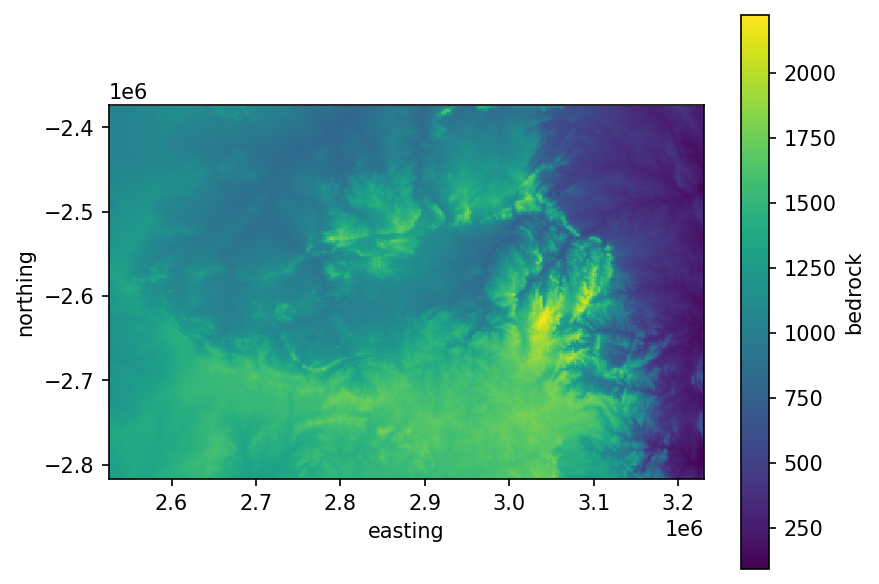

In [15]:
topo_plain.plot()
plt.gca().set_aspect("equal")
plt.show()

### Modelo da topografia com prismas

<img src="figuras/prisms.svg">

In [16]:
# Crie os prismas xarray.Dataset da topografia:
prisms_centers = (topo_plain.easting, topo_plain.northing)
surface = topo_plain.values
density = 2670 * np.ones_like(surface) # atribuir valores de densidade aos prismas

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface=surface,
    reference=0,
    properties={"density": density}
)
topo_prisms

<xarray.Dataset>
Dimensions:   (northing: 240, easting: 419)
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

### Calcule o efeito gravitacional da camada de prismas

In [17]:
# Defina as coordenadas onde vamos calcular o efeito da gravidade dos prismas
coordinates = (data.easting, data.northing, data.elevation)

# Use o "prism_layer" para  calcular o campo gravitacional da camada
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

### Cálculo do distúbio de gravidade Bouguer

In [18]:
bouguer_disturbance = data.gravity_disturbance - result
# Adicione o distúbio de gravidade Bouguer no conjunto de dados como uma coluna
data = data.assign(bouguer_disturbance=bouguer_disturbance)

data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouguer_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699,-89.537771
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458,-104.667670
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250,-110.810353
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660,-112.745806
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785,-132.450198
...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559,-41.415983
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034,14.551248
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540,20.407097
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373,-22.226792


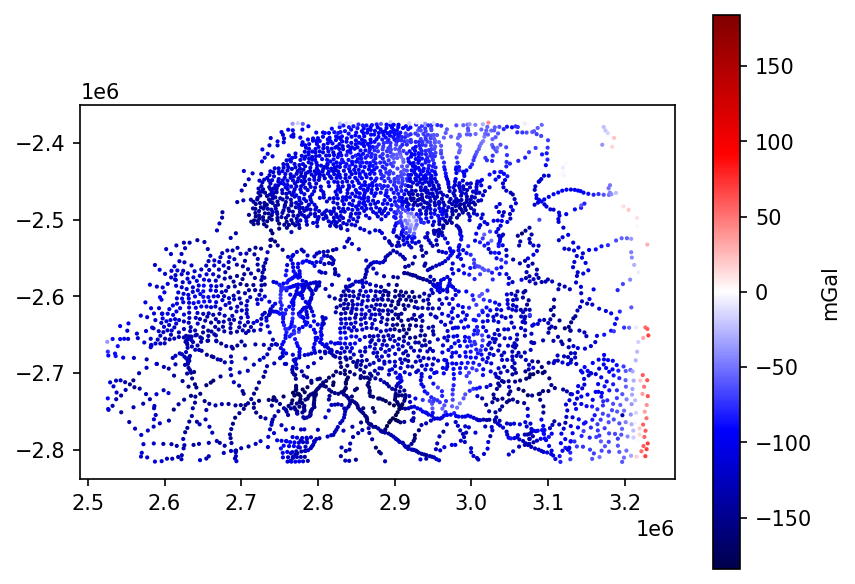

In [19]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(
    data.easting, data.northing, c=data.bouguer_disturbance, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic"
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Calcular resíduos: remover trend regional

Uma etapa de processamento comum é a remoção de tendências poliomiais 2D dos dados.
Isso geralmente ajuda os métodos de interpolação que podem se esforçar para recuperar os comprimentos de onda longos dos dados.

Para calcular o resíduo, usaremos [Verde](https://www.fatiando.org/verde).

In [20]:
# Calcule Trend distúrbio Bouguer usando um polinômio de segunda ordem:
trend = vd.Trend(degree=2)
trend.fit(coordinates, data.bouguer_disturbance)

# Remova o trend do distúrbio Bouguer:
residuals = data.bouguer_disturbance - trend.predict(coordinates)

In [21]:
# Adicione o resíduo ao conjunto de dados como uma coluna: 
data = data.assign(bouguer_residuals=residuals)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouguer_disturbance,bouguer_residuals
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699,-89.537771,20.704381
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458,-104.667670,5.406947
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250,-110.810353,-0.651089
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660,-112.745806,-1.889356
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785,-132.450198,-21.151576
...,...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559,-41.415983,16.009448
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034,14.551248,57.094729
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540,20.407097,59.109139
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373,-22.226792,33.196196


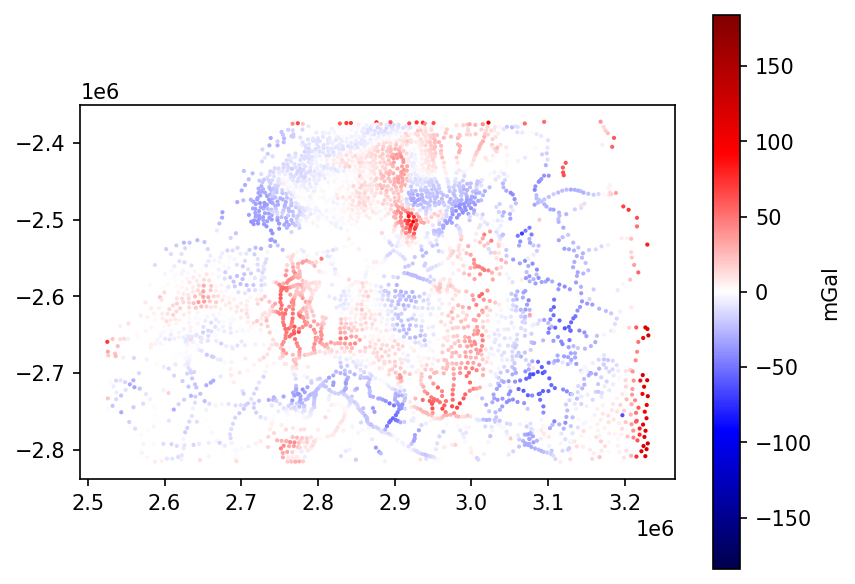

In [22]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(
    data.easting, data.northing, c=data.bouguer_residuals, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic"
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Grid de resíduos

Para fazer o grid do distúrbio dos resíduos, usaremos o _método da camada equivalente_.
A vantagem de usar este método é que leva em consideração a natureza 3D das observações, não apenas suas posições horizontais.
Ele também permite que a incerteza dos dados seja levada em consideração e o ruído seja suprimido através do processo de ajuste de mínimos quadrados.

Para este processamento, vamos usar o [Harmonica](https://www.fatiando.org/harmonica).

<img src="figuras/eql.svg">

In [23]:
# Cria a camada equivalente 
eql = hm.EQLHarmonic(damping=1e2, relative_depth=5e3)  # o parâmetro de amortecimento ajuda a suavizar os dados previstos e garantir a estabilidade.

# Ajuste os coeficientes de camada ao distúrbio residual observado:
eql.fit(coordinates, data.bouguer_residuals)

EQLHarmonic(damping=100.0, depth=5000.0)

In [24]:
data.elevation.max()

2144.0

In [25]:
longitude, latitude = vd.grid_coordinates(region=region_deg, spacing=0.01)

In [26]:
upward = np.zeros_like(longitude) +2200

In [27]:
upward = upward.reshape(longitude.shape)

In [28]:
Coordinates = [longitude,latitude,upward]

In [29]:
# Interpolar dados em uma grid regular:
grid = eql.grid(Coordinates,
                data_names=["bouguer_residuals"],
                dims=("latitude", "longitude"),
                projection=projection)

grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 -1.202 -1.214 ... 11.45
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, depth=5000.0)

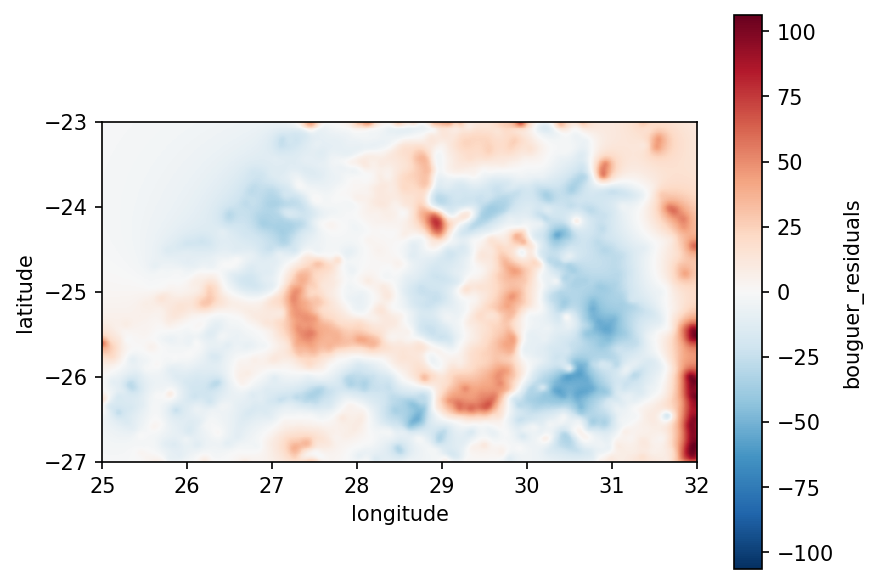

In [30]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")
plt.show()

In [31]:
grid = vd.convexhull_mask(data_coordinates=(data.longitude, data.latitude), grid=grid)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100.0, depth=5000.0)

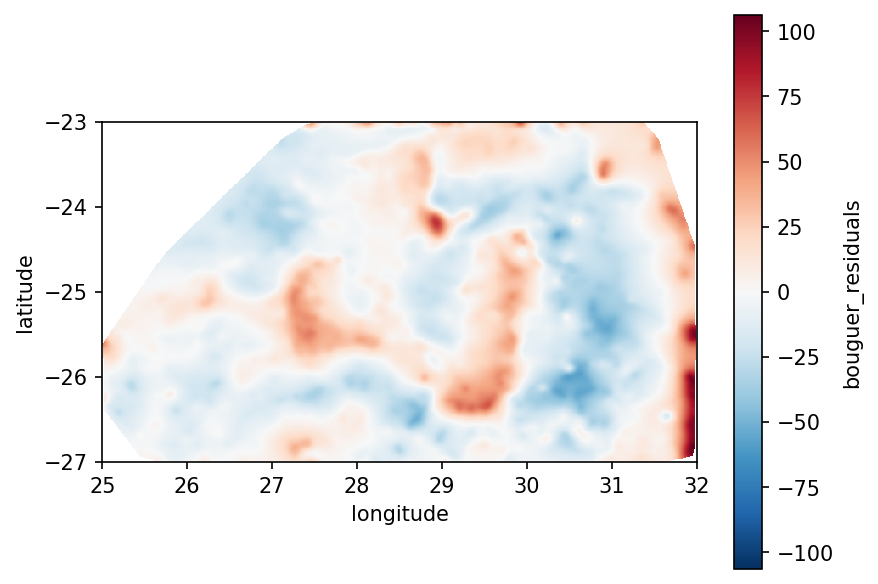

In [32]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")
plt.show()

<img src="img/study-area.png">

## Extrai um perfil

Vamos interpolar a perturbação residual ao longo de um perfil entre dois pontos usando uma camada equivalente.

In [33]:
point1 = (26, -25) # easting, northing 
point2 = (31, -25) 

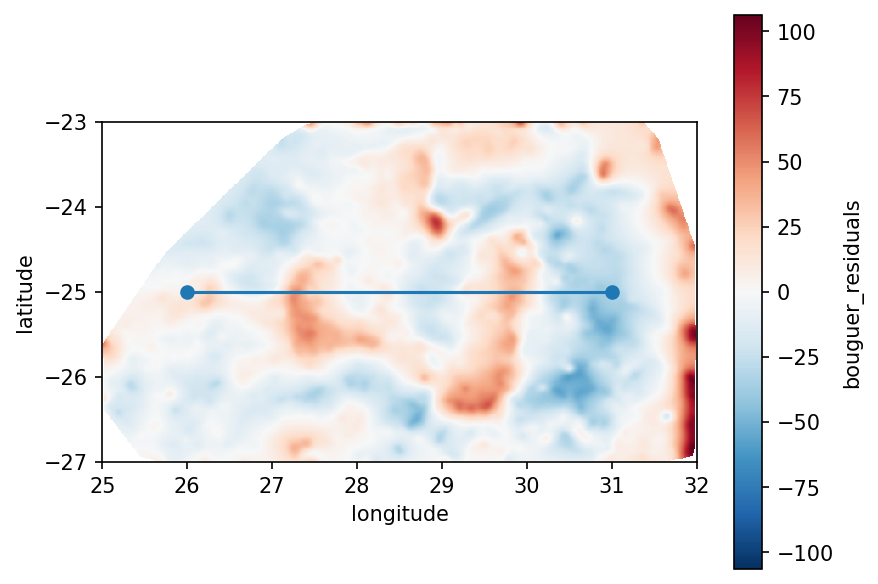

In [34]:
grid.bouguer_residuals.plot()
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], "o-")
plt.gca().set_aspect("equal")
plt.show()

In [35]:
profile = eql.profile(
    point1=point1,
    point2=point2,
    upward=data.elevation.max(),
    size=200,
    data_names=["bouguer_residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
profile

,latitude,longitude,distance,upward,bouguer_residuals
0,-25.0,26.000000,0.000000,2144.0,5.689327
1,-25.0,26.025126,2537.237799,2144.0,6.191257
2,-25.0,26.050251,5074.475598,2144.0,6.742877
3,-25.0,26.075377,7611.713397,2144.0,7.348475
4,-25.0,26.100503,10148.951197,2144.0,8.151086
...,...,...,...,...,...
195,-25.0,30.899497,494761.370830,2144.0,-37.588932
196,-25.0,30.924623,497298.608629,2144.0,-37.268892
197,-25.0,30.949749,499835.846428,2144.0,-36.725131
198,-25.0,30.974874,502373.084227,2144.0,-35.990387


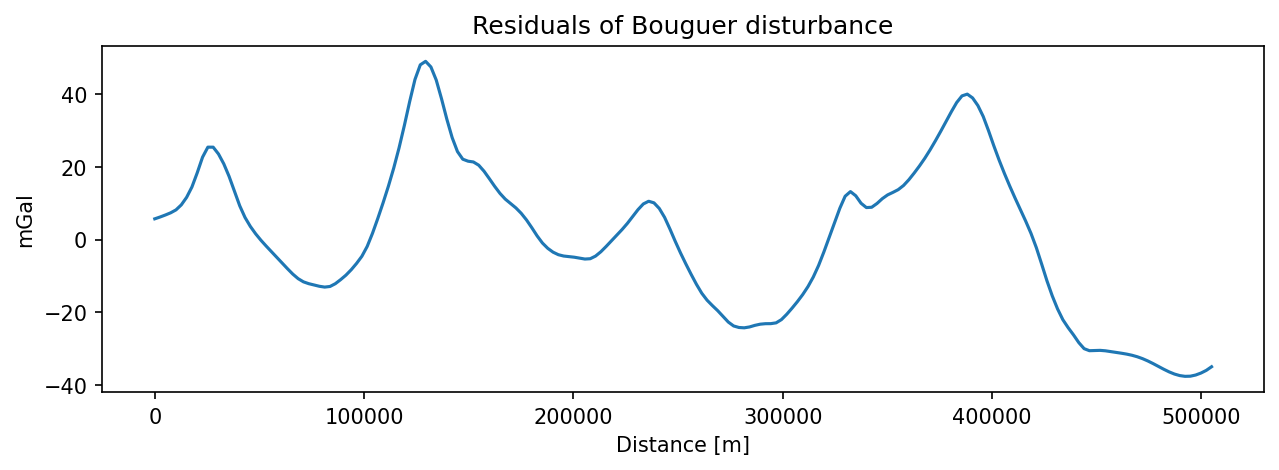

In [36]:
plt.plot(profile.distance, profile.bouguer_residuals)
plt.ylabel("mGal")
plt.xlabel("Distance [m]")
plt.title("Residuals of Bouguer disturbance")
plt.gcf().set_size_inches(10, 3)
plt.show()

## Salva o resultados 

In [37]:
# data.to_csv("south-africa-gravity-disturbance.csv")

In [38]:
# grid.to_netcdf("south-africa-residuals.nc")